In [20]:
#dependencies 
import numpy as np
import pandas as pd

In [21]:
#import cleaned data csv
all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
all_wells

,Unnamed: 0,WELL_BORE_CODE,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,FLOW_KIND,WELL_TYPE
0,15,NO 15/9-F-1 C,289.42,106.35,43.34,107.36,37.94,78.94,631.47,90439.09,0.00,production,OP
1,16,NO 15/9-F-1 C,270.24,107.64,47.17,99.19,60.76,70.63,1166.46,165720.39,0.00,production,OP
2,17,NO 15/9-F-1 C,262.84,107.87,47.73,94.60,63.05,66.05,1549.81,221707.31,0.00,production,OP
3,18,NO 15/9-F-1 C,255.53,107.97,48.53,89.99,64.55,61.41,1248.70,178063.52,0.00,production,OP
4,19,NO 15/9-F-1 C,247.20,108.05,49.84,84.78,65.72,56.15,1345.78,192602.19,0.00,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,8923,NO 15/9-F-15 D,194.98,106.52,31.58,15.81,49.02,1.26,144.01,23201.35,203.93,production,OP
5939,8924,NO 15/9-F-15 D,194.98,106.52,31.54,15.77,48.99,1.20,145.22,23068.07,202.93,production,OP
5940,8925,NO 15/9-F-15 D,194.32,106.52,31.52,15.70,50.10,1.28,142.74,23059.68,203.84,production,OP
5941,8926,NO 15/9-F-15 D,195.21,106.51,31.52,15.61,49.84,1.20,144.46,23090.47,202.76,production,OP


# Neural Network Analysis

### INPUTS: AVG_CHOKE_SIZE_P, AVG_WHP_P, AVG_WHT_P, BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL

In [22]:
#read in data for analysis 
X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
print(X1.shape)

(5943, 6)


In [23]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [25]:
#create the neural network
from tensorflow.keras.models import Sequential
model = Sequential()

In [26]:
#create the model
from tensorflow.keras.layers import Dense
number_inputs = X_train.shape[1]
number_hidden_nodes = 100

model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
model.add(Dense(number_hidden_nodes, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [27]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [28]:
#compile the model
from keras import losses

model.compile(loss="mean_absolute_error",
              optimizer="adam", metrics=[r_square, rmse])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               700       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
#early stopping tuning #1
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,verbose=0, mode='min')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 1s - loss: 0.6295 - r_square: 0.2888 - rmse: 0.6295 - val_loss: 0.5027 - val_r_square: 0.4800 - val_rmse: 0.5027
Epoch 2/100
1263/1263 - 0s - loss: 0.4379 - r_square: 0.5815 - rmse: 0.4379 - val_loss: 0.3834 - val_r_square: 0.6321 - val_rmse: 0.3834
Epoch 3/100
1263/1263 - 0s - loss: 0.3392 - r_square: 0.7095 - rmse: 0.3392 - val_loss: 0.3203 - val_r_square: 0.6846 - val_rmse: 0.3203
Epoch 4/100
1263/1263 - 0s - loss: 0.2806 - r_square: 0.7715 - rmse: 0.2806 - val_loss: 0.2980 - val_r_square: 0.6926 - val_rmse: 0.2980
Epoch 5/100
1263/1263 - 0s - loss: 0.2442 - r_square: 0.8188 - rmse: 0.2442 - val_loss: 0.2839 - val_r_square: 0.6923 - val_rmse: 0.2839
Epoch 6/100
1263/1263 - 0s - loss: 0.2244 - r_square: 0.8215 - rmse: 0.2244 - val_loss: 0.2767 - val_r_square: 0.6800 - val_rmse: 0.2767
Epoch 7/100
1263/1263 - 0s - loss: 0.2203 - r_square: 0.8315 - rmse: 0.2203 - val_loss: 0.2647 - val_r_square: 0.6862 - val_rmse: 0

In [31]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 21us/sample - loss: 0.1491 - r_square: 0.8638 - rmse: 0.1491


[0.1491281768334666, 0.86377335, 0.14912818]

In [32]:
#early stopping tuning #2
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_r_square', min_delta=0.000001, patience=5,verbose=0, mode='max')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 0s - loss: 0.1374 - r_square: 0.9003 - rmse: 0.1374 - val_loss: 0.1968 - val_r_square: 0.6748 - val_rmse: 0.1968
Epoch 2/100
1263/1263 - 0s - loss: 0.1350 - r_square: 0.8948 - rmse: 0.1350 - val_loss: 0.1882 - val_r_square: 0.6859 - val_rmse: 0.1882
Epoch 3/100
1263/1263 - 0s - loss: 0.1351 - r_square: 0.9055 - rmse: 0.1351 - val_loss: 0.1986 - val_r_square: 0.6768 - val_rmse: 0.1986
Epoch 4/100
1263/1263 - 0s - loss: 0.1376 - r_square: 0.9022 - rmse: 0.1376 - val_loss: 0.1898 - val_r_square: 0.6879 - val_rmse: 0.1898
Epoch 5/100
1263/1263 - 0s - loss: 0.1375 - r_square: 0.9036 - rmse: 0.1375 - val_loss: 0.2024 - val_r_square: 0.6869 - val_rmse: 0.2024
Epoch 6/100
1263/1263 - 0s - loss: 0.1358 - r_square: 0.9087 - rmse: 0.1358 - val_loss: 0.1878 - val_r_square: 0.6912 - val_rmse: 0.1878
Epoch 7/100
1263/1263 - 0s - loss: 0.1298 - r_square: 0.9048 - rmse: 0.1298 - val_loss: 0.2033 - val_r_square: 0.6876 - val_rmse: 0

1263/1263 - 0s - loss: 0.1186 - r_square: 0.9251 - rmse: 0.1186 - val_loss: 0.1772 - val_r_square: 0.7918 - val_rmse: 0.1772
Epoch 61/100
1263/1263 - 0s - loss: 0.1158 - r_square: 0.9237 - rmse: 0.1158 - val_loss: 0.1717 - val_r_square: 0.7905 - val_rmse: 0.1717
Epoch 62/100
1263/1263 - 0s - loss: 0.1156 - r_square: 0.9227 - rmse: 0.1156 - val_loss: 0.1730 - val_r_square: 0.7928 - val_rmse: 0.1730
Epoch 63/100
1263/1263 - 0s - loss: 0.1170 - r_square: 0.9204 - rmse: 0.1170 - val_loss: 0.1848 - val_r_square: 0.7883 - val_rmse: 0.1848
Epoch 64/100
1263/1263 - 0s - loss: 0.1164 - r_square: 0.9165 - rmse: 0.1164 - val_loss: 0.1755 - val_r_square: 0.7901 - val_rmse: 0.1755
Epoch 65/100
1263/1263 - 0s - loss: 0.1138 - r_square: 0.9223 - rmse: 0.1138 - val_loss: 0.1713 - val_r_square: 0.7948 - val_rmse: 0.1713
Epoch 66/100
1263/1263 - 0s - loss: 0.1157 - r_square: 0.9289 - rmse: 0.1157 - val_loss: 0.1777 - val_r_square: 0.7879 - val_rmse: 0.1777
Epoch 67/100
1263/1263 - 0s - loss: 0.1191 - r_

In [33]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 33us/sample - loss: 0.1162 - r_square: 0.9078 - rmse: 0.1162


[0.11616962148355443, 0.90783346, 0.11616962]

# Hyperas Tuning


In [34]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [35]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [36]:
#function to scale data for create model function
def data():
    #read in data for analysis 
    all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
    X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
    y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
    #split into test and train data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)
    from sklearn.preprocessing import StandardScaler
    # # Create a StandardScater model and fit it to the training data
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    # # Transform the training and testing data using the X_scaler and y_scaler models
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    x_train = X_train_scaled.reshape(-1,6)
    x_test = X_test_scaled.reshape(-1,6)
    y_train = y_train_scaled.reshape(-1,1)
    y_test = y_test_scaled.reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [37]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [53]:
#defining the create model function
exec('from __future__ import absolute_import, division, print_function')
from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras import backend as K

def create_model(x_train, y_train, x_test, y_test):
    print(x_train.shape)
    model= Sequential() 
    model.add(Dense({{choice([50,200,500])}}, input_dim=x_train.shape[1], activation= 'relu'))
    model.add(Dropout({{uniform(0,1)}}))
    model.add(Dense({{choice([50,200,500])}},activation= 'relu'))
    #model.add(Activation('relu'))
    model.add(Dropout({{uniform(0,1)}}))
    model.add(Dense(1, activation= 'linear'))

    
################################################
# CREDIT: https://github.com/keras-team/keras/issues/7947
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# mean squared error (mse) for regression  (only for Keras tensors)
    def mse(y_true, y_pred):
        from keras import backend
        return backend.mean(backend.square(y_pred - y_true), axis=-1)
    def r_square(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#############################################

    model.compile(loss='mean_absolute_error', optimizer= 'adam', metrics=[r_square, rmse])
    from keras.utils import print_summary
    print_summary(model, line_length=None, positions=None, print_fn=None)
    result= model.fit(x_train, y_train,
                      batch_size={{choice([64,128])}},
                      epochs={{choice([50,100,150])}},
                      verbose=2,
                      validation_split =0.15)
    validation_acc= np.min(result.history['val_loss'])
    print('Lowest Validation Loss:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}   

#finding the best model
best_run, best_model= optim.minimize(model=create_model,
                                     data=data,
                                     algo=tpe.suggest,
                                     max_evals=5,
                                     trials=Trials(),
                                     eval_space=True,
                                     notebook_name='NeuralAnalysis')
score= best_model.evaluate(X_test_scaled,y_test_scaled, batch_size= 64)

predictions_test = best_model.predict(X_test_scaled)
predictions_train = best_model.predict(X_train_scaled)

#print best model results
print('Evaluate:', score[0])
#print('Predictions:', predictions[:6])
print('Best Performing Model:', best_run)


>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras import losses
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:


 - 1s - loss: 0.6980 - r_square: 0.1314 - rmse: 0.6980 - val_loss: 0.4937 - val_r_square: 0.5740 - val_rmse: 0.4937    

Epoch 2/150                                                                                                            
 - 0s - loss: 0.5748 - r_square: 0.3907 - rmse: 0.5748 - val_loss: 0.4355 - val_r_square: 0.6562 - val_rmse: 0.4355    

Epoch 3/150                                                                                                            
 - 0s - loss: 0.5232 - r_square: 0.4821 - rmse: 0.5232 - val_loss: 0.4121 - val_r_square: 0.6932 - val_rmse: 0.4121    

Epoch 4/150                                                                                                            
 - 0s - loss: 0.4875 - r_square: 0.5501 - rmse: 0.4875 - val_loss: 0.3876 - val_r_square: 0.7204 - val_rmse: 0.3876    

Epoch 5/150                                                                                                            
 - 0s - loss: 0.4575 - r_square: 0.5

Epoch 35/150                                                                                                           
 - 0s - loss: 0.3029 - r_square: 0.7585 - rmse: 0.3029 - val_loss: 0.2630 - val_r_square: 0.8305 - val_rmse: 0.2630    

Epoch 36/150                                                                                                           
 - 0s - loss: 0.3005 - r_square: 0.7624 - rmse: 0.3005 - val_loss: 0.2693 - val_r_square: 0.8287 - val_rmse: 0.2693    

Epoch 37/150                                                                                                           
 - 0s - loss: 0.2936 - r_square: 0.7623 - rmse: 0.2936 - val_loss: 0.2657 - val_r_square: 0.8318 - val_rmse: 0.2657    

Epoch 38/150                                                                                                           
 - 0s - loss: 0.2962 - r_square: 0.7662 - rmse: 0.2962 - val_loss: 0.2520 - val_r_square: 0.8379 - val_rmse: 0.2520    

Epoch 39/150                        

 - 0s - loss: 0.2697 - r_square: 0.7904 - rmse: 0.2697 - val_loss: 0.2372 - val_r_square: 0.8535 - val_rmse: 0.2372    

Epoch 69/150                                                                                                           
 - 0s - loss: 0.2766 - r_square: 0.7848 - rmse: 0.2766 - val_loss: 0.2443 - val_r_square: 0.8494 - val_rmse: 0.2443    

Epoch 70/150                                                                                                           
 - 0s - loss: 0.2775 - r_square: 0.7885 - rmse: 0.2775 - val_loss: 0.2394 - val_r_square: 0.8517 - val_rmse: 0.2394    

Epoch 71/150                                                                                                           
 - 0s - loss: 0.2781 - r_square: 0.7862 - rmse: 0.2781 - val_loss: 0.2439 - val_r_square: 0.8484 - val_rmse: 0.2439    

Epoch 72/150                                                                                                           
 - 0s - loss: 0.2722 - r_square: 0.7

Epoch 102/150                                                                                                          
 - 0s - loss: 0.2568 - r_square: 0.8125 - rmse: 0.2568 - val_loss: 0.2436 - val_r_square: 0.8482 - val_rmse: 0.2436    

Epoch 103/150                                                                                                          
 - 0s - loss: 0.2632 - r_square: 0.7984 - rmse: 0.2632 - val_loss: 0.2282 - val_r_square: 0.8603 - val_rmse: 0.2282    

Epoch 104/150                                                                                                          
 - 0s - loss: 0.2648 - r_square: 0.7963 - rmse: 0.2648 - val_loss: 0.2318 - val_r_square: 0.8578 - val_rmse: 0.2318    

Epoch 105/150                                                                                                          
 - 0s - loss: 0.2675 - r_square: 0.8006 - rmse: 0.2675 - val_loss: 0.2308 - val_r_square: 0.8544 - val_rmse: 0.2308    

Epoch 106/150                       

 - 0s - loss: 0.2545 - r_square: 0.8121 - rmse: 0.2545 - val_loss: 0.2295 - val_r_square: 0.8616 - val_rmse: 0.2295    

Epoch 136/150                                                                                                          
 - 0s - loss: 0.2568 - r_square: 0.8054 - rmse: 0.2568 - val_loss: 0.2221 - val_r_square: 0.8639 - val_rmse: 0.2221    

Epoch 137/150                                                                                                          
 - 0s - loss: 0.2596 - r_square: 0.8104 - rmse: 0.2596 - val_loss: 0.2304 - val_r_square: 0.8564 - val_rmse: 0.2304    

Epoch 138/150                                                                                                          
 - 0s - loss: 0.2583 - r_square: 0.8123 - rmse: 0.2583 - val_loss: 0.2190 - val_r_square: 0.8669 - val_rmse: 0.2190    

Epoch 139/150                                                                                                          
 - 0s - loss: 0.2593 - r_square: 0.8

 - 0s - loss: 0.4400 - r_square: 0.6061 - rmse: 0.4400 - val_loss: 0.3868 - val_r_square: 0.7087 - val_rmse: 0.3868    

Epoch 9/50                                                                                                             
 - 1s - loss: 0.4243 - r_square: 0.6223 - rmse: 0.4243 - val_loss: 0.3538 - val_r_square: 0.7445 - val_rmse: 0.3538    

Epoch 10/50                                                                                                            
 - 0s - loss: 0.4166 - r_square: 0.6313 - rmse: 0.4166 - val_loss: 0.3492 - val_r_square: 0.7468 - val_rmse: 0.3492    

Epoch 11/50                                                                                                            
 - 1s - loss: 0.4143 - r_square: 0.6323 - rmse: 0.4143 - val_loss: 0.3421 - val_r_square: 0.7581 - val_rmse: 0.3421    

Epoch 12/50                                                                                                            
 - 0s - loss: 0.4081 - r_square: 0.6

Epoch 42/50                                                                                                            
 - 1s - loss: 0.3358 - r_square: 0.7385 - rmse: 0.3358 - val_loss: 0.2707 - val_r_square: 0.8210 - val_rmse: 0.2707    

Epoch 43/50                                                                                                            
 - 0s - loss: 0.3338 - r_square: 0.7287 - rmse: 0.3338 - val_loss: 0.2518 - val_r_square: 0.8325 - val_rmse: 0.2518    

Epoch 44/50                                                                                                            
 - 1s - loss: 0.3344 - r_square: 0.7373 - rmse: 0.3344 - val_loss: 0.2483 - val_r_square: 0.8359 - val_rmse: 0.2483    

Epoch 45/50                                                                                                            
 - 1s - loss: 0.3395 - r_square: 0.7316 - rmse: 0.3395 - val_loss: 0.2570 - val_r_square: 0.8320 - val_rmse: 0.2570    

Epoch 46/50                         

Epoch 15/100                                                                                                           
 - 0s - loss: 0.6999 - r_square: 0.1347 - rmse: 0.6999 - val_loss: 0.7504 - val_r_square: 0.1002 - val_rmse: 0.7504    

Epoch 16/100                                                                                                           
 - 0s - loss: 0.7136 - r_square: 0.0690 - rmse: 0.7136 - val_loss: 0.7498 - val_r_square: 0.1030 - val_rmse: 0.7498    

Epoch 17/100                                                                                                           
 - 0s - loss: 0.6976 - r_square: 0.1386 - rmse: 0.6976 - val_loss: 0.7498 - val_r_square: 0.1001 - val_rmse: 0.7498    

Epoch 18/100                                                                                                           
 - 0s - loss: 0.7031 - r_square: 0.1449 - rmse: 0.7031 - val_loss: 0.7566 - val_r_square: 0.0821 - val_rmse: 0.7566    

Epoch 19/100                        

 - 0s - loss: 0.6482 - r_square: 0.2175 - rmse: 0.6482 - val_loss: 0.7722 - val_r_square: 0.0472 - val_rmse: 0.7722    

Epoch 49/100                                                                                                           
 - 0s - loss: 0.6511 - r_square: 0.1934 - rmse: 0.6511 - val_loss: 0.7785 - val_r_square: 0.0339 - val_rmse: 0.7785    

Epoch 50/100                                                                                                           
 - 0s - loss: 0.6569 - r_square: 0.1966 - rmse: 0.6569 - val_loss: 0.7772 - val_r_square: 0.0358 - val_rmse: 0.7772    

Epoch 51/100                                                                                                           
 - 0s - loss: 0.6640 - r_square: 0.1923 - rmse: 0.6640 - val_loss: 0.7811 - val_r_square: 0.0274 - val_rmse: 0.7811    

Epoch 52/100                                                                                                           
 - 0s - loss: 0.6604 - r_square: 0.1

Epoch 82/100                                                                                                           
 - 0s - loss: 0.6366 - r_square: 0.2373 - rmse: 0.6366 - val_loss: 0.7838 - val_r_square: 0.0250 - val_rmse: 0.7838    

Epoch 83/100                                                                                                           
 - 0s - loss: 0.6522 - r_square: 0.1976 - rmse: 0.6522 - val_loss: 0.7839 - val_r_square: 0.0242 - val_rmse: 0.7839    

Epoch 84/100                                                                                                           
 - 0s - loss: 0.6458 - r_square: 0.2189 - rmse: 0.6458 - val_loss: 0.7853 - val_r_square: 0.0199 - val_rmse: 0.7853    

Epoch 85/100                                                                                                           
 - 0s - loss: 0.6440 - r_square: 0.2133 - rmse: 0.6440 - val_loss: 0.7854 - val_r_square: 0.0205 - val_rmse: 0.7854    

Epoch 86/100                        

Epoch 5/100                                                                                                            
 - 0s - loss: 0.4762 - r_square: 0.5499 - rmse: 0.4762 - val_loss: 0.3772 - val_r_square: 0.7293 - val_rmse: 0.3772    

Epoch 6/100                                                                                                            
 - 0s - loss: 0.4485 - r_square: 0.5828 - rmse: 0.4485 - val_loss: 0.3643 - val_r_square: 0.7435 - val_rmse: 0.3643    

Epoch 7/100                                                                                                            
 - 0s - loss: 0.4285 - r_square: 0.6181 - rmse: 0.4285 - val_loss: 0.3467 - val_r_square: 0.7573 - val_rmse: 0.3467    

Epoch 8/100                                                                                                            
 - 0s - loss: 0.4280 - r_square: 0.6181 - rmse: 0.4280 - val_loss: 0.3218 - val_r_square: 0.7761 - val_rmse: 0.3218    

Epoch 9/100                         

 - 0s - loss: 0.3198 - r_square: 0.7449 - rmse: 0.3198 - val_loss: 0.2340 - val_r_square: 0.8503 - val_rmse: 0.2340    

Epoch 39/100                                                                                                           
 - 0s - loss: 0.3248 - r_square: 0.7334 - rmse: 0.3248 - val_loss: 0.2326 - val_r_square: 0.8496 - val_rmse: 0.2326    

Epoch 40/100                                                                                                           
 - 0s - loss: 0.3203 - r_square: 0.7434 - rmse: 0.3203 - val_loss: 0.2336 - val_r_square: 0.8515 - val_rmse: 0.2336    

Epoch 41/100                                                                                                           
 - 0s - loss: 0.3110 - r_square: 0.7571 - rmse: 0.3110 - val_loss: 0.2288 - val_r_square: 0.8537 - val_rmse: 0.2288    

Epoch 42/100                                                                                                           
 - 0s - loss: 0.3182 - r_square: 0.7

Epoch 72/100                                                                                                           
 - 0s - loss: 0.2957 - r_square: 0.7752 - rmse: 0.2957 - val_loss: 0.2107 - val_r_square: 0.8654 - val_rmse: 0.2107    

Epoch 73/100                                                                                                           
 - 0s - loss: 0.3015 - r_square: 0.7641 - rmse: 0.3015 - val_loss: 0.2140 - val_r_square: 0.8650 - val_rmse: 0.2140    

Epoch 74/100                                                                                                           
 - 0s - loss: 0.3053 - r_square: 0.7648 - rmse: 0.3053 - val_loss: 0.2174 - val_r_square: 0.8646 - val_rmse: 0.2174    

Epoch 75/100                                                                                                           
 - 0s - loss: 0.3015 - r_square: 0.7710 - rmse: 0.3015 - val_loss: 0.2091 - val_r_square: 0.8669 - val_rmse: 0.2091    

Epoch 76/100                        

_________________________________________________________________                                                      
dense_44 (Dense)             (None, 200)               100200                                                          
_________________________________________________________________                                                      
dropout_30 (Dropout)         (None, 200)               0                                                               
_________________________________________________________________                                                      
dense_45 (Dense)             (None, 1)                 201                                                             
Total params: 103,901                                                                                                  
Trainable params: 103,901                                                                                              
Non-trainable params: 0                 

Epoch 29/50                                                                                                            
 - 0s - loss: 0.1600 - r_square: 0.8557 - rmse: 0.1600 - val_loss: 0.1344 - val_r_square: 0.9022 - val_rmse: 0.1344    

Epoch 30/50                                                                                                            
 - 0s - loss: 0.1558 - r_square: 0.8698 - rmse: 0.1558 - val_loss: 0.1328 - val_r_square: 0.9016 - val_rmse: 0.1328    

Epoch 31/50                                                                                                            
 - 0s - loss: 0.1575 - r_square: 0.8689 - rmse: 0.1575 - val_loss: 0.1378 - val_r_square: 0.9025 - val_rmse: 0.1378    

Epoch 32/50                                                                                                            
 - 0s - loss: 0.1599 - r_square: 0.8661 - rmse: 0.1599 - val_loss: 0.1384 - val_r_square: 0.9037 - val_rmse: 0.1384    

Epoch 33/50                         

In [59]:
best_model.metrics_names

['loss', 'r_square', 'rmse']

In [64]:
x_train, y_train, x_test, y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test, verbose=3))

Evalutation of best performing model:
[0.8025105784911647, -0.0095308106392622, 0.802510678768158]


In [50]:
#using model to predict y values
# predictions = best_model.predict(X_test_scaled)
# predictions1 = best_model.predict(X_train_scaled)
# predictions1
#predictions= test
#predictions1= train 


array([[ 0.11042935],
       [-0.02757291],
       [ 0.08504621],
       ...,
       [-0.08176664],
       [-0.07878926],
       [-0.07380855]], dtype=float32)

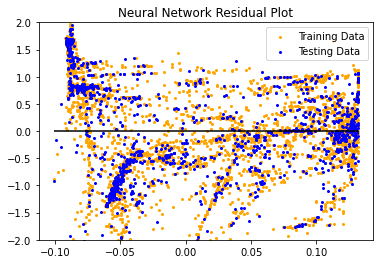

In [54]:
# Plot Residuals
import matplotlib.pyplot as plt

plt.title('Neural Network Residual Plot')
plt.scatter(predictions1, predictions1 - y_train_scaled, c= "orange",label="Training Data", s=4)
plt.scatter(predictions, predictions - y_test_scaled, c= "blue",label="Testing Data",s=4)
plt.ylim(-2,2)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.legend()

plt.savefig('neuralnetworkresidual.png')
plt.show()

In [55]:
# Score the prediction with mse and r2
from sklearn.metrics import mean_squared_error, r2_score
mse_train = mean_squared_error(y_train_scaled, predictions1)
r2_train = r2_score(y_train_scaled, predictions1)

In [56]:
mse_test = mean_squared_error(y_test_scaled, predictions)
r2_test = r2_score(y_test_scaled, predictions)

In [57]:
print(f"Mean Squared Error (MSE) Train Data: {mse_train}")
print(f"R-squared (R2) Train Data: {r2_train}")
print("-----------------------------------")
print(f"Mean Squared Error (MSE) Test Data: {mse_test}")
print(f"R-squared (R2) Test Data: {r2_test}")

Mean Squared Error (MSE) Train Data: 0.9695344313476822
R-squared (R2) Train Data: 0.030465568652317976
-----------------------------------
Mean Squared Error (MSE) Test Data: 0.9560464283070286
R-squared (R2) Test Data: 0.02794750287581882


# NEW Neural Network


In [ ]:
'Dense': 50, 'Dense_1': 500, 'Dropout': 0.9758185183456943, 'Dropout_1': 0.288662535902546, 'batch_size': 64, 'epochs': 100}

In [66]:
#create the model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
number_inputs = X_train.shape[1]
#first dense
model.add(Dense(units=50,
                activation='relu', input_dim=number_inputs))
#first dropout
model.add(Dropout(0.9758185183456943))
#second dense
model.add(Dense(500, kernel_initializer='normal',activation='relu'))
#second dropout
model.add(Dropout(0.288662535902546))
#last dense layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [67]:
#compile the model
from keras import losses

model.compile(loss="mean_absolute_error",
              optimizer="adam", metrics=[r_square, rmse])

In [68]:
x_train, y_train, x_test, y_test = data()
model.fit(x_train,y_train,epochs=100, shuffle=True, validation_split=.15, verbose=2)

Train on 3788 samples, validate on 669 samples
Epoch 1/100
3788/3788 - 2s - loss: 0.6239 - r_square: 0.2548 - rmse: 0.6239 - val_loss: 0.6230 - val_r_square: 0.3358 - val_rmse: 0.6230
Epoch 2/100
3788/3788 - 1s - loss: 0.5560 - r_square: 0.3449 - rmse: 0.5560 - val_loss: 0.6734 - val_r_square: 0.2297 - val_rmse: 0.6734
Epoch 3/100
3788/3788 - 1s - loss: 0.5554 - r_square: 0.3437 - rmse: 0.5554 - val_loss: 0.7021 - val_r_square: 0.1668 - val_rmse: 0.7021
Epoch 4/100
3788/3788 - 1s - loss: 0.5295 - r_square: 0.3882 - rmse: 0.5295 - val_loss: 0.7251 - val_r_square: 0.1088 - val_rmse: 0.7251
Epoch 5/100
3788/3788 - 1s - loss: 0.5373 - r_square: 0.3599 - rmse: 0.5373 - val_loss: 0.7303 - val_r_square: 0.1004 - val_rmse: 0.7303
Epoch 6/100
3788/3788 - 1s - loss: 0.5302 - r_square: 0.3740 - rmse: 0.5302 - val_loss: 0.7262 - val_r_square: 0.0972 - val_rmse: 0.7262
Epoch 7/100
3788/3788 - 1s - loss: 0.5221 - r_square: 0.3741 - rmse: 0.5221 - val_loss: 0.7377 - val_r_square: 0.0764 - val_rmse: 0

Epoch 57/100
3788/3788 - 1s - loss: 0.5084 - r_square: 0.3763 - rmse: 0.5084 - val_loss: 0.7790 - val_r_square: -2.3721e-02 - val_rmse: 0.7790
Epoch 58/100
3788/3788 - 1s - loss: 0.5022 - r_square: 0.3944 - rmse: 0.5022 - val_loss: 0.7766 - val_r_square: -1.9441e-02 - val_rmse: 0.7766
Epoch 59/100
3788/3788 - 0s - loss: 0.5050 - r_square: 0.3942 - rmse: 0.5050 - val_loss: 0.7761 - val_r_square: -1.9069e-02 - val_rmse: 0.7761
Epoch 60/100
3788/3788 - 0s - loss: 0.5138 - r_square: 0.3816 - rmse: 0.5138 - val_loss: 0.7753 - val_r_square: -1.7307e-02 - val_rmse: 0.7753
Epoch 61/100
3788/3788 - 0s - loss: 0.5054 - r_square: 0.3830 - rmse: 0.5054 - val_loss: 0.7706 - val_r_square: -1.1960e-02 - val_rmse: 0.7706
Epoch 62/100
3788/3788 - 0s - loss: 0.5061 - r_square: 0.3866 - rmse: 0.5061 - val_loss: 0.7746 - val_r_square: -1.8148e-02 - val_rmse: 0.7746
Epoch 63/100
3788/3788 - 0s - loss: 0.5020 - r_square: 0.4144 - rmse: 0.5020 - val_loss: 0.7736 - val_r_square: -1.6318e-02 - val_rmse: 0.7736

In [69]:
print("Evalutation of best performing model:")
print(model.evaluate(x_test, y_test, verbose=3))

Evalutation of best performing model:
[0.7785015925263653, -0.0045601293, 0.77850163]


In [71]:
from sklearn.metrics import mean_squared_error, r2_score
mse_train = mean_squared_error(y_train_scaled, predictions1)
r2_train = r2_score(y_train_scaled, predictions1)

mse_test = mean_squared_error(y_test_scaled, predictions)
r2_test = r2_score(y_test_scaled, predictions)

print(f"Mean Squared Error (MSE) Train Data: {mse_train}")
print(f"R-squared (R2) Train Data: {r2_train}")
print("-----------------------------------")
print(f"Mean Squared Error (MSE) Test Data: {mse_test}")
print(f"R-squared (R2) Test Data: {r2_test}")

Mean Squared Error (MSE) Train Data: 0.9695344313476822
R-squared (R2) Train Data: 0.030465568652317976
-----------------------------------
Mean Squared Error (MSE) Test Data: 0.9560464283070286
R-squared (R2) Test Data: 0.02794750287581882
